In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation,performance_metrics

Loading CSVs

In [3]:
#uses pathlib to get current working directory that's not operating system specific
current_directory = Path.cwd()
csv_path = current_directory / 'CX_Net_generation_United_States_all_sectors_monthly.csv'
df = pd.read_csv(csv_path)

#pulls relevant columns and renames them with proper naming conventions
df = df[['Month', 'total_fuels_MWh', 'coal_MWh', 'natural gas thousand megawatthours', 'nuclear thousand megawatthours', 'conventional hydroelectric thousand megawatthours']]
df.columns = ['date', 'total_fuels_MWh', 'coal_MWh','natural_gas_MWh', 'nuclear_MWh', 'hydroelectric_MWh']
df.head()

,date,total_fuels_MWh,coal_MWh,natural_gas_MWh,nuclear_MWh,hydroelectric_MWh
0,2001-01-01,332493160.0,177287.111,42388663.0,68707077.0,18852048.0
1,2001-02-01,282940198.0,149735.484,37966927.0,61272407.0,17472889.0
2,2001-03-01,300706544.0,155269.011,44364414.0,62140712.0,20477189.0
3,2001-04-01,278078871.0,140670.654,45842746.0,56003026.0,18012994.0
4,2001-05-01,300491621.0,151592.914,50934205.0,61512445.0,19175635.0


In [4]:
#convert 'date' from object(string) to datetime
df['date'] = pd. to_datetime(df['date']) 

In [5]:
df_total = df[['date', 'total_fuels_MWh']]
df_total.columns = ['ds', 'y']

In [6]:
df_total.head()

,ds,y
0,2001-01-01,332493160.0
1,2001-02-01,282940198.0
2,2001-03-01,300706544.0
3,2001-04-01,278078871.0
4,2001-05-01,300491621.0


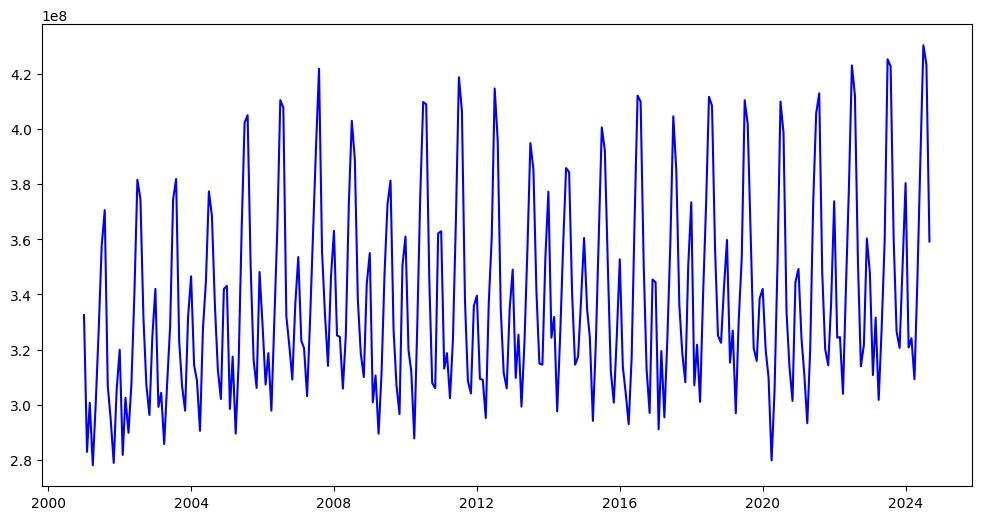

In [7]:
#first create a matpotlib graph with date on the x axis and total_fuels on the y
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['total_fuels_MWh'], label='Total Fuels (MWh)', color='blue')

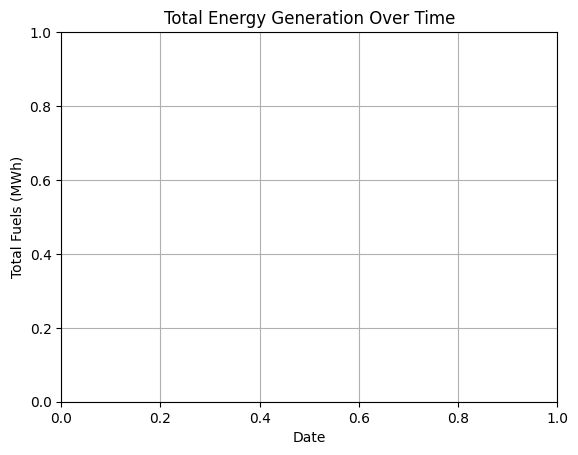

In [8]:
plt.xlabel('Date')
plt.ylabel('Total Fuels (MWh)')
plt.title('Total Energy Generation Over Time')
plt.grid(True)

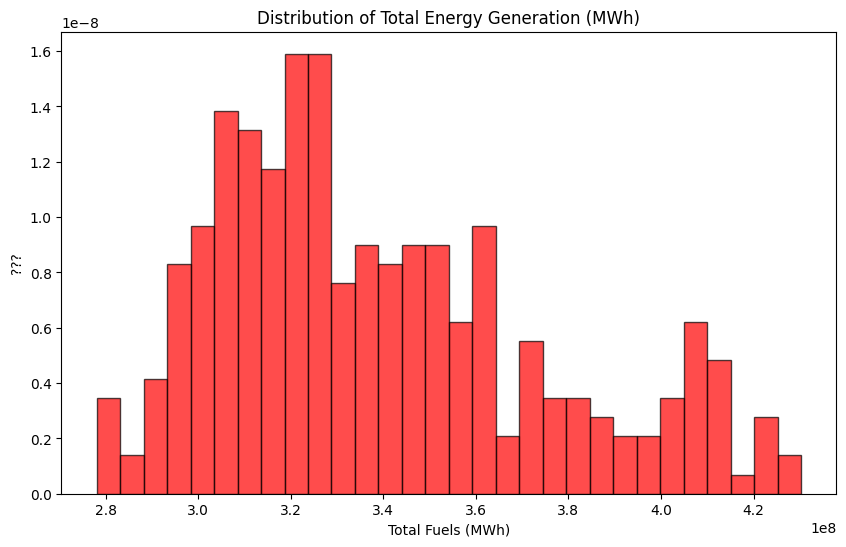

In [9]:
#create a histogram distribution (matplotlib) of y (for continuous values) ask chatgpt that.  Should look like a bell curve
plt.figure(figsize=(10,6))
plt.hist(df['total_fuels_MWh'], bins=30, color='red', edgecolor='black', alpha=0.7, density=True)
plt.xlabel('Total Fuels (MWh)')
plt.ylabel('???')
plt.title('Distribution of Total Energy Generation (MWh)')
plt.show()

In [10]:
#statstics metrics like mean median mode, std, etc.
mean=df_total.mean()
med=df_total.median()
mode=df_total.mode()
stdev=df_total.std()
print(f"Mean: {mean}")
print(f"Median: {med}")
print(f"Standard Deviation: {mode}")
print(f": {stdev}")

Mean: ds    2012-10-31 01:05:41.052631552
y                   338762769.63614
dtype: object
Median: ds    2012-11-01 00:00:00
y             330615570.0
dtype: object
Standard Deviation:             ds            y
0   2001-01-01  278078871.0
1   2001-02-01  278933942.0
2   2001-03-01  279846213.8
3   2001-04-01  281825712.0
4   2001-05-01  282940198.0
..         ...          ...
280 2024-05-01  422681773.8
281 2024-06-01  422974982.5
282 2024-07-01  423354768.8
283 2024-08-01  425220301.6
284 2024-09-01  430287610.6

[285 rows x 2 columns]
: ds    2508 days 13:04:21.414679456
y                  35430747.655839
dtype: object


In [11]:
#are there any NaN values?  
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      285 non-null    datetime64[ns]
 1   y       285 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 KB


There are no NaN values

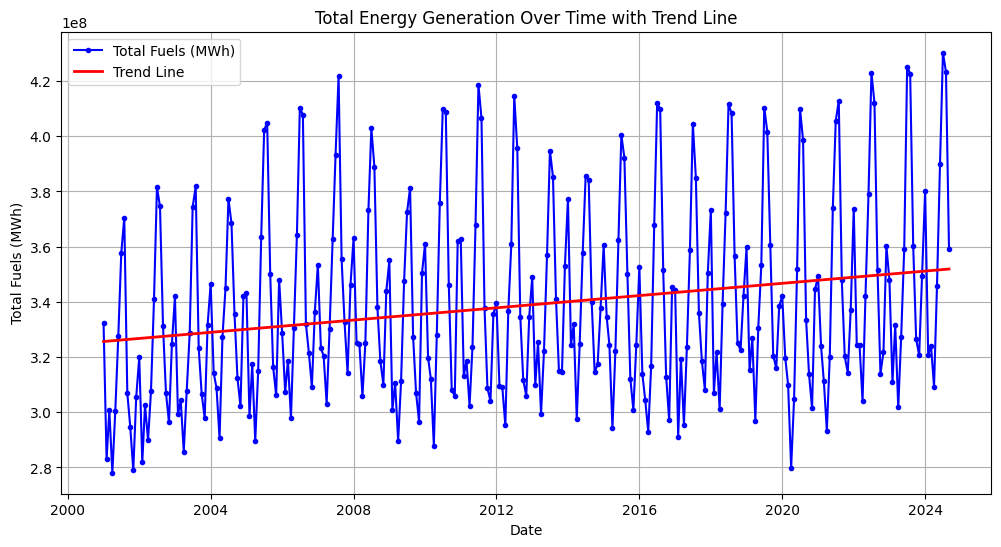

In [12]:
#add a trend line to your matplotlib graph
# Sort values by date to ensure proper plotting
df = df.sort_values(by='date')

# Convert dates to numerical values for regression 
df['date_ordinal'] = df['date'].map(lambda x: x.toordinal())

# Fit a linear trend line 
trend = np.polyfit(df['date_ordinal'], df['total_fuels_MWh'], 1)
trend_line = np.poly1d(trend)

plt.figure(figsize=(12,6))
plt.plot(df['date'], df['total_fuels_MWh'], label='Total Fuels (MWh)', linestyle='-', marker='o', markersize=3, color='blue')

plt.plot(df['date'], trend_line(df['date_ordinal']), color='red', linewidth=2, label='Trend Line')

plt.xlabel('Date')
plt.ylabel('Total Fuels (MWh)')
plt.title('Total Energy Generation Over Time with Trend Line')
plt.legend()
plt.grid(True)

plt.show()

This is a linear trend line

In [13]:
#setting the index to the date
df_total = df_total.set_index('ds')

#converting 1st day of month to last day of month to match hw_df
df_total = df_total.shift(periods=1,freq='ME')

In [14]:
#resetting index so format complies with fbprophet
df_total = df_total.reset_index(drop=False)

In [35]:
months_out = 60

In [36]:
model = Prophet()
model.fit(df_total)
future_df = model.make_future_dataframe(periods=months_out,freq='ME')
forecast_df = model.predict(future_df)

22:49:55 - cmdstanpy - INFO - Chain [1] start processing
22:49:55 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
def compare(actuals_df,forecast_df):
    
    actuals  = actuals_df[['ds','y']][:-(months_out-1)].set_index('ds',drop=True)
    forecast = forecast_df[['ds','yhat']][:-(months_out-1)].set_index('ds',drop=True)
    compare  = pd.concat([actuals, forecast], axis=1)
    compare.columns = ['Actuals','Forecast']    
    
    year_begin = compare.index.year[0].astype(str)
    year_end = compare.index.year[-1].astype(str)
    
    title='X MA Actuals vs. Forecasted Revenue \n' + year_begin + ' - ' + year_end
    ylabel='Revenue (millions)'
    xlabel=''
    
    ax = compare['Actuals'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    ax2 = compare['Forecast'].plot(legend=True, label='Forecast',marker='o',color='#FF0066')
    
    ax.autoscale(axis='x',tight=True)
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False);
    
    return compare

,Actuals,Forecast
ds,,
2001-01-31,332493160.0,3.269656e+08
2001-02-28,282940198.0,2.855984e+08
2001-03-31,300706544.0,2.903788e+08
2001-04-30,278078871.0,2.698291e+08
2001-05-31,300491621.0,2.988615e+08
...,...,...
2024-06-30,NaN,3.802337e+08
2024-07-31,NaN,4.187101e+08
2024-08-31,NaN,4.111023e+08


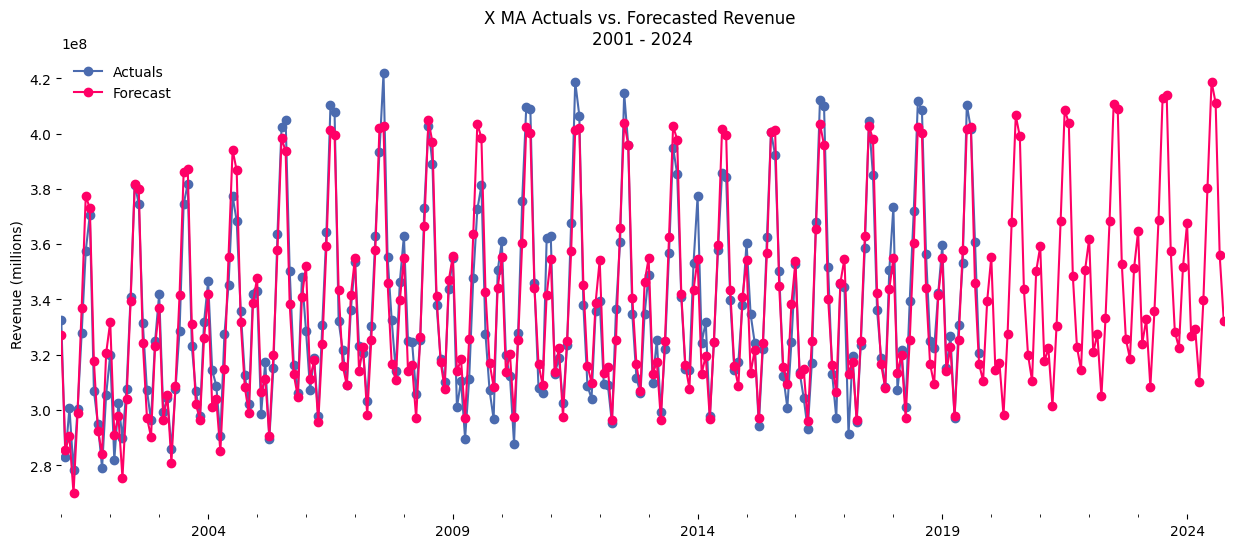

In [38]:
compare(df_total,forecast_df)

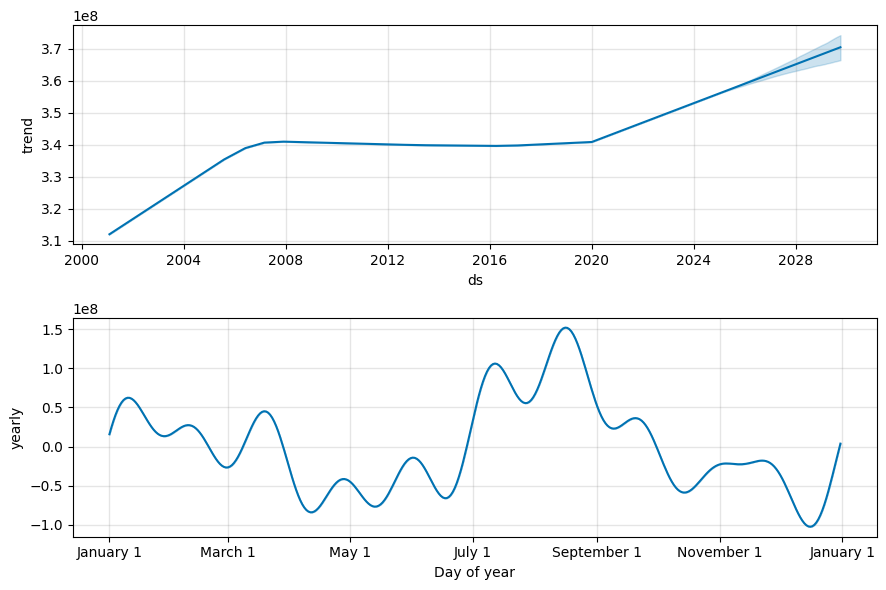

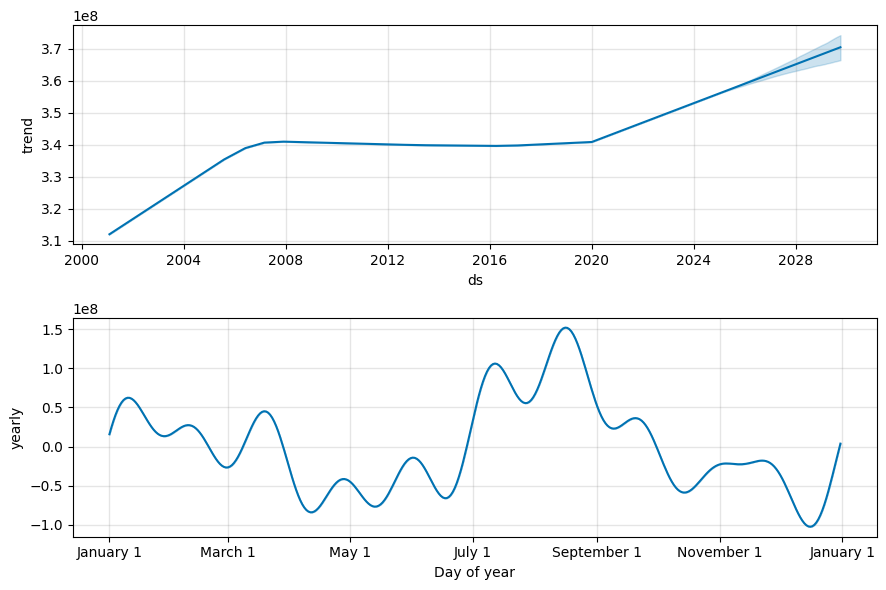

In [39]:
model.plot_components(forecast_df)

In [40]:
def accuracy(model,months_out):
    
    cv_df = cross_validation(model, horizon  = str(30.4167*months_out) + ' days'
                                  , period   = str(30.4167) + ' days'
                                  , parallel ='processes')
    pm_df = performance_metrics(cv_df)
    
    pm_df['accuracy'] = (1 - pm_df['mape']).round(3)
    pm_df['days out'] = pm_df['horizon']
    pm_df['months out'] = pm_df['months out'] = (((pm_df['horizon'].astype(str).str[:3].str.strip().str.replace(' d','').astype(int))/30).round(3)).astype(str)
    pm_df['months out'] = pm_df['months out'].astype(float).astype(int)
    pm_df['Forecast Model'] = 'X MA'
    pm_df = pm_df[['Forecast Model', 'days out', 'months out', 'mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage','accuracy']]
    pm_df.columns = ['Forecast Model', 'Days Out', 'Months Out', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE', 'Coverage', 'Accuracy']
    
    return pm_df.groupby(['Forecast Model','Months Out'], as_index=False).mean()

In [41]:
accuracy(model,months_out)

22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing
22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain 

,Forecast Model,Months Out,Days Out,MSE,RMSE,MAE,MAPE,MDAPE,Coverage,Accuracy
0,X MA,3,1093 days 15:34:13.302857136,8.510837e+13,9.223041e+06,7.523678e+06,0.021984,0.020154,0.740615,0.978102
1,X MA,4,1352 days 09:43:08.160000,1.045040e+14,1.021260e+07,8.452846e+06,0.024430,0.021849,0.700785,0.975584
2,X MA,5,1656 days 17:46:20.160000,1.353854e+14,1.163355e+07,9.673212e+06,0.027262,0.024439,0.670070,0.972804
3,X MA,6,1643 days 08:33:18.528000,1.361592e+14,1.165239e+07,9.251763e+06,0.025675,0.021582,0.668401,0.974356
4,X MA,7,211 days 01:12:29.622857144,9.981558e+13,9.990679e+06,7.916228e+06,0.022749,0.017395,0.690742,0.977000
5,X MA,8,241 days 09:23:56.160000,1.020832e+14,1.010340e+07,7.988835e+06,0.023041,0.016818,0.691615,0.976978
6,X MA,9,271 days 19:31:56.160000,1.063461e+14,1.031210e+07,8.132169e+06,0.023610,0.016488,0.693432,0.976400
7,X MA,10,302 days 05:39:56.160000,1.107674e+14,1.052436e+07,8.282399e+06,0.024203,0.016838,0.692111,0.975822
8,X MA,11,332 days 16:19:56.160000,1.147273e+14,1.071075e+07,8.398352e+06,0.024684,0.017200,0.687154,0.975244
9,X MA,12,363 days 02:27:56.160000,1.185881e+14,1.088948e+07,8.489304e+06,0.025078,0.017370,0.684841,0.975000


In [43]:
forecast_df.to_csv('forecast.csv')